# Peter e il Lupo: Introduzione al Reinforcement Learning

In questo tutorial, impareremo come applicare il Reinforcement Learning a un problema di ricerca del percorso. L'ambientazione è ispirata alla fiaba musicale [Peter e il Lupo](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) del compositore russo [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). È la storia del giovane pioniere Peter, che coraggiosamente esce di casa per raggiungere la radura nella foresta e inseguire il lupo. Addestreremo algoritmi di machine learning che aiuteranno Peter a esplorare l'area circostante e a costruire una mappa di navigazione ottimale.

Per prima cosa, importiamo alcune librerie utili:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Panoramica dell'Apprendimento per Rinforzo

**L'Apprendimento per Rinforzo** (RL) è una tecnica di apprendimento che ci permette di apprendere un comportamento ottimale di un **agente** in un determinato **ambiente** eseguendo molti esperimenti. Un agente in questo ambiente dovrebbe avere un **obiettivo**, definito da una **funzione di ricompensa**.

## L'Ambiente

Per semplicità, consideriamo il mondo di Peter come una scacchiera di dimensioni `width` x `height`. Ogni cella di questa scacchiera può essere:
* **terra**, su cui Peter e altre creature possono camminare
* **acqua**, su cui ovviamente non si può camminare
* **un albero** o **erba** - un luogo dove ci si può riposare
* **una mela**, che rappresenta qualcosa che Peter sarebbe felice di trovare per nutrirsi
* **un lupo**, che è pericoloso e dovrebbe essere evitato

Per lavorare con l'ambiente, definiremo una classe chiamata `Board`. Per non appesantire troppo questo notebook, abbiamo spostato tutto il codice per lavorare con la scacchiera in un modulo separato chiamato `rlboard`, che importeremo ora. Puoi dare un'occhiata a questo modulo per ottenere maggiori dettagli sugli aspetti interni dell'implementazione.


In [2]:
from rlboard import *

Creiamo ora una scacchiera casuale e vediamo come appare:


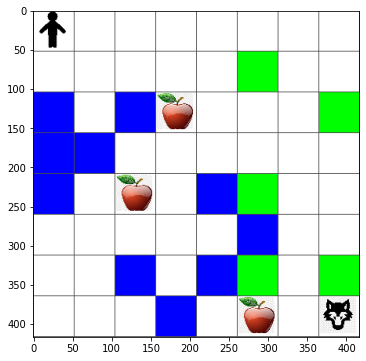

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Azioni e Politica

Nel nostro esempio, l'obiettivo di Peter sarebbe trovare una mela, evitando il lupo e altri ostacoli. Per fare ciò, può essenzialmente camminare in giro finché non trova una mela. Pertanto, in qualsiasi posizione può scegliere tra una delle seguenti azioni: su, giù, sinistra e destra. Definiremo queste azioni come un dizionario e le mapperemo a coppie di corrispondenti cambiamenti di coordinate. Ad esempio, muoversi a destra (`R`) corrisponderebbe a una coppia `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

La strategia del nostro agente (Peter) è definita da quella che viene chiamata **policy**. Consideriamo la policy più semplice, chiamata **cammino casuale**.

## Cammino casuale

Iniziamo risolvendo il nostro problema implementando una strategia di cammino casuale.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Facciamo l'esperimento di passeggiata casuale più volte e vediamo il numero medio di passi effettuati:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Funzione di Ricompensa

Per rendere la nostra politica più intelligente, dobbiamo capire quali mosse sono "migliori" rispetto ad altre.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Apprendimento Q

Costruisci una Q-Table, o un array multidimensionale. Poiché la nostra griglia ha dimensioni `width` x `height`, possiamo rappresentare la Q-Table con un array numpy di forma `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Passa la Q-Table alla funzione di plot per visualizzare la tabella sulla board:


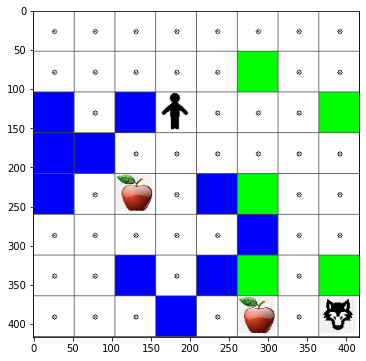

In [9]:
m.plot(Q)

## Essenza del Q-Learning: Equazione di Bellman e Algoritmo di Apprendimento

Scrivi un pseudo-codice per il nostro algoritmo di apprendimento:

* Inizializza la Q-Table Q con numeri uguali per tutti gli stati e le azioni
* Imposta il tasso di apprendimento $\alpha\leftarrow 1$
* Ripeti la simulazione molte volte
   1. Inizia da una posizione casuale
   1. Ripeti
        1. Seleziona un'azione $a$ nello stato $s$
        2. Esegui l'azione spostandoti in un nuovo stato $s'$
        3. Se si verifica una condizione di fine gioco, o il totale del premio è troppo basso - esci dalla simulazione  
        4. Calcola il premio $r$ nel nuovo stato
        5. Aggiorna la funzione Q secondo l'equazione di Bellman: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Aggiorna il totale del premio e diminuisci $\alpha$.

## Sfruttare vs. Esplorare

L'approccio migliore è bilanciare tra esplorazione e sfruttamento. Man mano che impariamo di più sul nostro ambiente, saremo più propensi a seguire il percorso ottimale, tuttavia, scegliendo di tanto in tanto una strada inesplorata.

## Implementazione in Python

Ora siamo pronti per implementare l'algoritmo di apprendimento. Prima di farlo, abbiamo anche bisogno di una funzione che converta numeri arbitrari nella Q-Table in un vettore di probabilità per le azioni corrispondenti:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Aggiungiamo una piccola quantità di `eps` al vettore originale per evitare la divisione per 0 nel caso iniziale, quando tutti i componenti del vettore sono identici.

L'algoritmo di apprendimento effettivo che eseguiremo per 5000 esperimenti, chiamati anche **epoche**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Dopo l'esecuzione di questo algoritmo, la Q-Table dovrebbe essere aggiornata con valori che definiscono l'attrattiva delle diverse azioni in ogni fase. Visualizza la tabella qui:


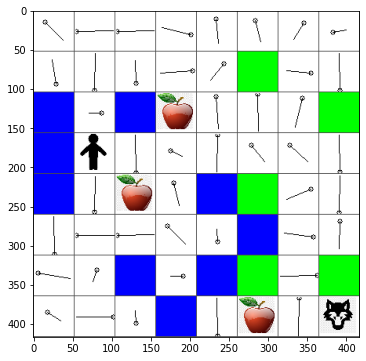

In [12]:
m.plot(Q)

## Verifica della Politica

Poiché la Q-Table elenca l'"attrattività" di ogni azione in ogni stato, è abbastanza semplice utilizzarla per definire la navigazione efficiente nel nostro mondo. Nel caso più semplice, possiamo semplicemente selezionare l'azione corrispondente al valore più alto nella Q-Table:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Se provi il codice sopra diverse volte, potresti notare che a volte si "blocca" e devi premere il pulsante STOP nel notebook per interromperlo.

> **Attività 1:** Modifica la funzione `walk` per limitare la lunghezza massima del percorso a un certo numero di passi (ad esempio, 100), e osserva come il codice sopra restituisce questo valore di tanto in tanto.

> **Attività 2:** Modifica la funzione `walk` in modo che non torni nei luoghi in cui è già stato in precedenza. Questo impedirà a `walk` di entrare in un ciclo, tuttavia, l'agente potrebbe comunque finire "intrappolato" in una posizione da cui non è in grado di uscire.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


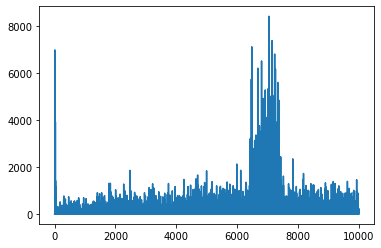

In [15]:
plt.plot(lpath)

Quello che osserviamo qui è che inizialmente la lunghezza media del percorso è aumentata. Questo probabilmente è dovuto al fatto che, quando non sappiamo nulla sull'ambiente, è più probabile rimanere intrappolati in stati sfavorevoli, come acqua o lupi. Man mano che impariamo di più e iniziamo a utilizzare queste conoscenze, possiamo esplorare l'ambiente per periodi più lunghi, ma non sappiamo ancora bene dove si trovano le mele.

Una volta che abbiamo imparato abbastanza, diventa più facile per l'agente raggiungere l'obiettivo, e la lunghezza del percorso inizia a diminuire. Tuttavia, siamo ancora aperti all'esplorazione, quindi spesso ci allontaniamo dal percorso migliore ed esploriamo nuove opzioni, rendendo il percorso più lungo rispetto all'ottimale.

Osserviamo anche in questo grafico che, a un certo punto, la lunghezza è aumentata bruscamente. Questo indica la natura stocastica del processo e il fatto che, a un certo punto, possiamo "rovinare" i coefficienti della Q-Table sovrascrivendoli con nuovi valori. Idealmente, questo dovrebbe essere minimizzato riducendo il tasso di apprendimento (cioè, verso la fine dell'addestramento, si dovrebbero regolare i valori della Q-Table solo di una piccola quantità).

In generale, è importante ricordare che il successo e la qualità del processo di apprendimento dipendono significativamente dai parametri, come il tasso di apprendimento, la decadenza del tasso di apprendimento e il fattore di sconto. Questi sono spesso chiamati **iperparametri**, per distinguerli dai **parametri** che ottimizziamo durante l'addestramento (ad esempio, i coefficienti della Q-Table). Il processo di ricerca dei migliori valori per gli iperparametri si chiama **ottimizzazione degli iperparametri**, e merita un argomento a sé stante.


## Esercizio
#### Un mondo più realistico di Peter e il Lupo

Nella nostra situazione, Peter è stato in grado di muoversi quasi senza stancarsi o avere fame. In un mondo più realistico, deve sedersi e riposarsi di tanto in tanto, e anche nutrirsi. Rendiamo il nostro mondo più realistico implementando le seguenti regole:

1. Spostandosi da un luogo all'altro, Peter perde **energia** e accumula un po' di **fatica**.
2. Peter può recuperare energia mangiando mele.
3. Peter può eliminare la fatica riposandosi sotto l'albero o sull'erba (cioè camminando in una posizione della griglia con un albero o dell'erba - campo verde).
4. Peter deve trovare e uccidere il lupo.
5. Per uccidere il lupo, Peter deve avere determinati livelli di energia e fatica, altrimenti perde la battaglia.

Modifica la funzione di ricompensa sopra in base alle regole del gioco, esegui l'algoritmo di apprendimento per rinforzo per apprendere la strategia migliore per vincere il gioco e confronta i risultati del cammino casuale con il tuo algoritmo in termini di numero di partite vinte e perse.

> **Nota**: Potresti dover regolare gli iperparametri per far funzionare il tutto, in particolare il numero di epoche. Poiché il successo del gioco (combattere il lupo) è un evento raro, puoi aspettarti tempi di addestramento molto più lunghi.



---

**Disclaimer**:  
Questo documento è stato tradotto utilizzando il servizio di traduzione AI [Co-op Translator](https://github.com/Azure/co-op-translator). Sebbene ci impegniamo per garantire l'accuratezza, si prega di notare che le traduzioni automatizzate possono contenere errori o imprecisioni. Il documento originale nella sua lingua nativa dovrebbe essere considerato la fonte autorevole. Per informazioni critiche, si raccomanda una traduzione professionale effettuata da un esperto umano. Non siamo responsabili per eventuali incomprensioni o interpretazioni errate derivanti dall'uso di questa traduzione.
